### Taylor Slaton
### Skyler Tran

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score
from scipy.special import expit

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 

# upload data

In [0]:
#read in data
original_data = pd.read_csv('./clinvar-conflicting/clinvar_conflicting.csv')

In [0]:
# Data summary
print(original_data.dtypes)
print('===========')
# print(data.info())

REF            object
ALT            object
AF_EXAC       float64
AF_TGP        float64
ORIGIN        float64
CLASS           int64
IMPACT         object
EXON           object
SIFT           object
PolyPhen       object
CADD_PHRED    float64
CADD_RAW      float64
dtype: object


# Lab 3 : Extending Logistic Regression

## Dataset Selection

Select a dataset identically to the way you selected for the lab one (i.e., table data). You are not required to use the same dataset that you used in the past, but you are encouraged. You must identify a classification task from the dataset that contains three or more classes to predict. That is it cannot be a binary classification; it must be multi-class prediction. 

## Preparation and Overview [***30 points***]

### ***20 points***
Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the classification task is and what parties would be interested in the results. For example, would the model be deployed or use mostly for offline analysis? 

*Explain answer here*

The Genetic Variant Classifications dataset is a dataset that contains information on whether labs have classified different genetic variants in different ways. Variants are classified by clinical laboratories on whether a variant is considered benign, likely benign, uncertain, likely pathogenic, or pathogenic. This is how these classifications come to be, but it is possible that different labs will classify variants differently. When the difference is between benign and likely benign or pathogenic and likely pathogenic, the difference isn't that significant. However, when the differences are between benign or pathogenic the issue is much larger. This dataset takes this data and compiles whether or not these clinical labs have identified these variants differently. This is a problem that causes clinicians and researches to not necessarily know how to give a patient advice or how to continue with the found variant. This can cause a mix of false positives and significantly more problematic false negatives. <br> 
Our plan for this data set is to find a way to show people if their genetic variant falls within this gray area to be able seek a second opinion to keep themselves safe. This can also affect medical professionals, as they may be looking at conflicting data and not know what to tell their patient. <br />

Our classification goal is to train a dataset on the patterns of conflicting classifications from different labs, as well as those that do not conflict. We will also be looking at the proteins and the allele patterns to see what is most likely pathogenic and what is most likely benign. The goal is to make an algorithm that medical professionals can use to be able to see what labs to listen to and what a genetic variant is classified more as, so that they can give their patients the proper information for their health, and if they should seek more opinions.
<br />
This model would be used for offline analysis. The algorithm would run on the database and end with some form of chart or graph that a medical professional could look at when dealing with a certain genetic variant. The medical professional would not plug in a variant and wait, as the data is already collected. This system would run and then whatever data was found would be used by the medical professional from then on, until more lab results are added to the database and the algorithm is run again.

### ***5 points***
 (mostly the same processes as from previous labs) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

*Explain answer here*

| Name               | Type     | Level of<br>Measurement                                                   | Possibilities                                                                                                                                            | Explanation                                                                                                                                                                                                          | Kept? |
|--------------------|----------|---------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------|
| CHROM              | object   | Ordinal*<br>* Chromosomes<br>are <br>recognized<br>in a specific<br>order | Between 1 and 22                                                                                                                                         | Chromosome the variant is located on                                                                                                                                                                                 | No    |
| POS                | int 64   | Interval                                                                  | Between 961 and 248                                                                                                                                      | Position on the chromosome the variant<br> is located on                                                                                                                                                             | No    |
| REF                | object   | Nominal                                                                   | a, c, t, g                                                                                                                                               | Reference Allele                                                                                                                                                                                                     | Yes   |
| ALT                | object   | Nominal                                                                   | a, c, t, g                                                                                                                                               | Alternate Allele                                                                                                                                                                                                     | Yes   |
| AF_ESP             | float 64 | Interval                                                                  | Between 0 and 0.5                                                                                                                                        | Allele frequencies from GO-ESP                                                                                                                                                                                       | No    |
| AF_EXAC            | float 64 | Interval                                                                  | Between 0 and 0.5                                                                                                                                        | Allele frequencies from ExAC                                                                                                                                                                                         | Yes   |
| AF_TGP             | float 64 | Interval                                                                  | Between 0 and 0.5                                                                                                                                        | Allele frequencies from the 1000<br> genomes project                                                                                                                                                                 | Yes   |
| CLNDISDB           | object   | Nominal                                                                   | Formula:<br>  OMIM:NNNNNN                                                                                                                                | Tag-value pairs of disease database<br> name and identifier                                                                                                                                                          | No    |
| CLNDISDBINCL       | object   | Nominal                                                                   | Formula:<br>  OMIM:NNNNNN                                                                                                                                | Tag-value pairs of disease database<br> name and identifier for included <br> variant                                                                                                                                | No    |
| CLNDN              | object   | Nominal                                                                   | Strings representing<br> a name                                                                                                                          | ClinVar's preferred disease name<br> for the concept specified by <br> disease identifiers in CLNDISDB                                                                                                               | No    |
| CLNDNINCL          | object   | Nominal                                                                   | null                                                                                                                                                     | ClinVar's preferred disease name<br> for the concept specified by <br> disease identifiers in CLNDISDB<br> for included variant                                                                                      | No    |
| CLNHGVS            | object   | Nominal                                                                   | Unique values                                                                                                                                            | Top-level HGVS* expression<br>* A standard made for describing<br>  variants, mutations, or <br>  polymorphisms                                                                                                      | No    |
| CLNSIGINCL         | object   | Nominal                                                                   | Formula<br> VariationID:clinical significance                                                                                                            | Clinical significance for a<br> haplotype* or genotype* that<br> includes this variant<br>* Group of genes within an<br>  organism inherited from<br>  a single parent<br>* An organism's genetic <br>  constitution | No    |
| CLNVC              | object   | Nominal                                                                   | single_nucleotide_variant<br>deletion                                                                                                                    | Variant Type                                                                                                                                                                                                         | No    |
| CLNVI              | object   | Nominal                                                                   | Formula<br> UniProtKB_(protein):LNNNNN                                                                                                                   | Variant's clinical sources reported<br> as tag-value pairs of database and <br> variant identifier                                                                                                                   | No    |
| MC                 | object   | Nominal                                                                   | Formula<br> SO:NNNNNNN|molecular_consequence                                                                                                             | Coma separated list of molecular<br> consequences in the form of <br> Sequence Ontology*<br>* A way to define sequence features                                                                                      | No    |
| ORIGIN             | float 64 | Nominal                                                                   | unknown<br>germline<br>somatic<br>inherited<br>paternal<br>maternal<br>denovo<br>biparental<br>uniparental<br>not-tested<br>tested-inconclusive<br>other | Allele Origin                                                                                                                                                                                                        | Yes   |
| SSR                | float 64 | Nominal                                                                   | 0 - unspecified<br>1 - Paralog<br>2 - byEST<br>4 - oldAlign<br>8 - Para_EST<br>16 - 1kg_failed<br>1024 - other                                           | Variant Suspect Reason Codes                                                                                                                                                                                         | No    |
| CLASS              | int 64   | Nominal                                                                   | 0 - no conflict<br>1 - conflict                                                                                                                          | Binary representation of the target<br> class                                                                                                                                                                        | Yes   |
| Allele             | object   | Nominal                                                                   | a, c, t, g                                                                                                                                               | Variant allele used to calculate the<br> consequence                                                                                                                                                                 | No    |
| Consequences       | object   | Nominal                                                                   | 48 different values                                                                                                                                      | Type of consequence                                                                                                                                                                                                  | No    |
| IMPACT             | object   | Ordinal                                                                   | LOW<br>MODERATE<br>MODIFIER                                                                                                                              | The impact modifier for the consequence<br> type                                                                                                                                                                     | Yes   |
| SYMBOL             | object   | Nominal                                                                   | 2329 different values                                                                                                                                    | Gene Name                                                                                                                                                                                                            | No    |
| Feature_type       | object   | Nominal                                                                   | Transcript<br>RegulatoryFeature<br>MotifFeature                                                                                                          | Type of feature                                                                                                                                                                                                      | No    |
| Feature            | object   | Nominal                                                                   | Formula<br> LL_NNNNNN.N<br> *Differing number of N                                                                                                       | Ensemble stable ID of feature                                                                                                                                                                                        | No    |
| BIOTYPE            | object   | Nominal                                                                   | protein_coding                                                                                                                                           | Biotype of transcript or regulatory<br> feature                                                                                                                                                                      | No    |
| EXON               | object   | Ratio                                                                     | Formula <br> NN/39<br> *Differing number of N                                                                                                            | Exon* number<br>* Type of amino acid                                                                                                                                                                                 | Yes   |
| INTRON             | object   | Ratio                                                                     | Formula <br> NN/38<br> *Differing number of N                                                                                                            | Intron* number<br>* Segment of DNA or RNA that<br>  interrupts sequence of genes                                                                                                                                     | No    |
| cDNA_position      | object   | Interval                                                                  | Numeric Values                                                                                                                                           | Relative position of base pair in the<br> cDNA* sequence<br>* DNA from a single-strand RNA                                                                                                                           | Yes   |
| CDS_position       | object   | Interval                                                                  | Numeric Values                                                                                                                                           | Relative position of base pair in the<br> coding sequence                                                                                                                                                            | No    |
| Protein_position   | object   | Interval                                                                  | Numeric Values                                                                                                                                           | Relative position of amino acid in <br>protein                                                                                                                                                                       | No    |
| Amino_acids        | object   | Nominal                                                                   | Formula<br> L<br> *Representing a protein                                                                                                                | Only given if the variant affects the<br> protein-coding sequence                                                                                                                                                    | No    |
| Codons             | object   | Nominal                                                                   | strand of a, c, t, g                                                                                                                                     | Alternative codons* with the variant <br>affects the protein-coding sequence<br>* Sequence of 3 DNA/RNA that <br>  represents an amino acid or<br>  stop signal                                                      | No    |
| DISTANCE           | float 64 | Interval                                                                  | Between 1 and 4759                                                                                                                                       | Shortest distance from variant to <br> transcript                                                                                                                                                                    | No    |
| STRAND             | float 64 | Nominal                                                                   | 1 - forward<br>-1 - reverse                                                                                                                              | Defined as forward or reverse                                                                                                                                                                                        | No    |
| BAM_EDIT           | object   | Nominal                                                                   | OK<br>Failed<br>null                                                                                                                                     | Indicates success or failure of edit<br> using BAM file                                                                                                                                                              | No    |
| SIFT               | object   | Ordinal                                                                   | tolerated<br>deleterious<br>deleterious_low_confidence<br>tolerated_low_confidence<br>null                                                               | SIFT prediction* and/or score, with<br> both given as prediction<br>* Does an amino acid substitution<br>  affect the protein of the sequence                                                                        | Yes   |
| PolyPhen           | object   | Ordinal                                                                   | benign<br>probably_damaging<br>possibly_damaging<br>null                                                                                                 | PolyPhen* prediction and/or score<br>* Polymorphism Phenotyping, or<br>  amino acid substitution affect                                                                                                              | Yes   |
| MOTIF_NAME         | object   | Nominal                                                                   | null<br>Egr1:MA0341.1<br>FOXA1:MA0546.1                                                                                                                  | Source and identifier of a<br> transcription factor binding<br> profile aligned at this position                                                                                                                     | No    |
| MOTIF_POS          | float 64 | Interval                                                                  | null<br>1                                                                                                                                                | Relative position of the variation<br> in the aligned TFBP*<br>* Transferrin-binding Protein, or<br>  iron-binding blood plasma                                                                                      | No    |
| HIGH_INF_POS       | object   | Nominal                                                                   | null<br>N                                                                                                                                                | Flag indicating if the variant<br> falls in a high information<br> position of a transcription<br> factor binding profile                                                                                            | No    |
| MOTIF_SCORE_CHANGE | float 64 | Interval                                                                  | null<br>-0.063<br>-0.097                                                                                                                                 | Difference in motif score* of the<br> reference and variant sequences<br> for the TFBP<br>* Genomic sequences that specifically<br>  bind to transcription factors                                                   | No    |
| LoFtool            | float 64 | Ratio                                                                     | Between 0 and 1                                                                                                                                          | Loss of Function tolerance score<br> for the loss of function variants                                                                                                                                               | No    |
| CADD_PHRED         | float 64 | Interval                                                                  | Between 0 and 99                                                                                                                                         | Phred-scaled CADD score*<br>* Rank of variant relative to <br>  substitution of human reference<br>  genome                                                                                                          | Yes   |
| CADD_RAW           | float 64 | Interval                                                                  | Between -5.48 and 46.6                                                                                                                                   | Score of the deleteriousness*<br> of variants<br>* A genetic alteration that increases<br>  how susceptibility to a disease                                                                                          | No    |
| BLOSUM62           | float 64 | Ordinal                                                                   | Between -3 and 3                                                                                                                                         | Scoring matrix for protein strings*<br>* how much does two sequences match                                                                                                                                           | No    |



In summary,  we kept origin (the reference as to where the variant is located), impact (how much the variant could impact the person), ref (the allele that the variant changes), alt (the allele that it changed to), AF_EXAC and AF_TGP (frequencies of these variants), CADD_PHRED (a rank of substitution), EXON (type of amino acid), class (whether there's a conflict or not), sift (how much does this affect the genome), PolyPhen (the substitution affect), and cDNA_position (the position of the base pair). We did not end up creating any specific variables, as this dataset had all the necessary information within already existing variables.



In [0]:
# preprocess variables
# dimensionality reduction
# scaling
# remove vars
# create vars

In [0]:
# Remove attributes that just arent useful for us
# Removing features that aren't useful for our purposes (Columns that has less than 50% of data are deleted)
for feat in ['DISTANCE', 'SSR', 'CLNDNINCL', 'CLNSIGINCL', 'CLNDISDBINCL', 'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS', 'MOTIF_SCORE_CHANGE',
            'BAM_EDIT', 'CLNVI', 'BLOSUM62', 'INTRON', 'Feature_type', 'BIOTYPE', 'Feature']:
  if feat in original_data:
    del original_data[feat]
original_data

,REF,ALT,AF_EXAC,AF_TGP,ORIGIN,CLASS,IMPACT,EXON,SIFT,PolyPhen,CADD_PHRED,CADD_RAW
0,G,T,0.00289,0.0010,1.0,0,MODIFIER,363/363,NaN,NaN,11.170,1.091042
1,A,G,0.00063,0.0004,1.0,1,LOW,363/363,NaN,NaN,1.437,-0.142156
2,C,A,0.00004,0.0000,1.0,0,MODERATE,363/363,NaN,NaN,23.000,3.385304
3,GT,G,0.00001,0.0000,1.0,0,HIGH,363/363,NaN,NaN,63.000,25.726748
4,A,C,0.00000,0.0000,1.0,1,MODERATE,363/363,NaN,NaN,20.400,2.630719
...,...,...,...,...,...,...,...,...,...,...,...,...
62907,G,A,0.00000,0.0000,1.0,0,MODIFIER,NaN,NaN,NaN,24.400,4.556305
62908,T,C,0.00000,0.0000,1.0,1,MODIFIER,NaN,NaN,NaN,3.016,0.043467
62909,T,C,0.00000,0.0000,1.0,1,MODIFIER,NaN,NaN,NaN,2.860,0.027997
62910,T,C,0.00000,0.0000,1.0,1,MODIFIER,NaN,NaN,NaN,2.081,-0.055831


In [0]:
categorical = ['IMPACT', 'SIFT', 'PolyPhen']
len(categorical)

unique_cat_values = []
total_non_nans = []
# make df for # unique values in the categorical features
for feat in categorical:
  unique_cat_values.append(original_data[feat].nunique())
  total_non_nans.append(original_data[feat].count())
unique_cat_values = pd.DataFrame({'Feature': categorical, 'Num_unique': unique_cat_values})
total_non_nans = pd.DataFrame({'Feature': categorical, 'Non_Nan_Count': total_non_nans})
unique_cat_values
total_non_nans

,Feature,Non_Nan_Count
0,IMPACT,62912
1,SIFT,24772
2,PolyPhen,24732


## Subset of the data

For the purpose of this lab, we only use records that have PolyPhen value.

In [0]:
# We need to convert EXON to a ratio.  Right now the entries are like 1/10 instead
# of .1 so we need to process that.
subset_data_list = ['ORIGIN', 'IMPACT', 'REF', 'ALT', 'AF_EXAC', 'AF_TGP',
                    'CADD_PHRED', 'EXON', 'CLASS', 'SIFT', 'PolyPhen']

subset_data = original_data[subset_data_list]
print(subset_data.info())
subset_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62912 entries, 0 to 62911
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ORIGIN      56789 non-null  float64
 1   IMPACT      62912 non-null  object 
 2   REF         62912 non-null  object 
 3   ALT         62912 non-null  object 
 4   AF_EXAC     62912 non-null  float64
 5   AF_TGP      62912 non-null  float64
 6   CADD_PHRED  62554 non-null  float64
 7   EXON        54028 non-null  object 
 8   CLASS       62912 non-null  int64  
 9   SIFT        24772 non-null  object 
 10  PolyPhen    24732 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 5.3+ MB
None


,ORIGIN,IMPACT,REF,ALT,AF_EXAC,AF_TGP,CADD_PHRED,EXON,CLASS,SIFT,PolyPhen
0,1.0,MODIFIER,G,T,0.00289,0.0010,11.170,363/363,0,NaN,NaN
1,1.0,LOW,A,G,0.00063,0.0004,1.437,363/363,1,NaN,NaN
2,1.0,MODERATE,C,A,0.00004,0.0000,23.000,363/363,0,NaN,NaN
3,1.0,HIGH,GT,G,0.00001,0.0000,63.000,363/363,0,NaN,NaN
4,1.0,MODERATE,A,C,0.00000,0.0000,20.400,363/363,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
62907,1.0,MODIFIER,G,A,0.00000,0.0000,24.400,NaN,0,NaN,NaN
62908,1.0,MODIFIER,T,C,0.00000,0.0000,3.016,NaN,1,NaN,NaN
62909,1.0,MODIFIER,T,C,0.00000,0.0000,2.860,NaN,1,NaN,NaN
62910,1.0,MODIFIER,T,C,0.00000,0.0000,2.081,NaN,1,NaN,NaN


### Cleaning Subset Data

Now we need to fix the EXON column to hold numeric ratio values 

In [0]:
# Fix EXON
# subset_cc_data.EXON.apply(lambda x: np.nan if x.startswith('XXX') else x)
def make_ratio(x):
  fin = np.nan
  try:
    vals = x.split('/')
    fin = float(vals[0]) / float(vals[-1])
  except:
    return fin 
  return fin
subset_data.EXON = subset_data.EXON.apply(lambda x: make_ratio(x))
# convert EXON to float datatype 
subset_data.EXON = subset_data.EXON.astype(float)

C:\Users\Skyler\Anaconda3\envs\mlenv\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [0]:
subset_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62912 entries, 0 to 62911
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ORIGIN      56789 non-null  float64
 1   IMPACT      62912 non-null  object 
 2   REF         62912 non-null  object 
 3   ALT         62912 non-null  object 
 4   AF_EXAC     62912 non-null  float64
 5   AF_TGP      62912 non-null  float64
 6   CADD_PHRED  62554 non-null  float64
 7   EXON        23004 non-null  float64
 8   CLASS       62912 non-null  int64  
 9   SIFT        24772 non-null  object 
 10  PolyPhen    24732 non-null  object 
dtypes: float64(5), int64(1), object(5)
memory usage: 5.3+ MB


### Imputation

We decided to use the KNN algorithm to impute our dataset. We chose KNN for the following reasons:

KNN can impute all types of data (ordinal, categorical, etc.) if the distance metric is defined for each type of data. Although our categorical data is not missing any values, if we added to this dataset or if the dataset was expanded and had missing data once expanded, we could use our same imputation implementation as opposed to changing. Although sklearn does not seem to support this yet, there are other libraries that are able to do this.

KNN is non-parametric which means that it does not make assumptions about the underlying data distributions. This is important because some of our data may not conform to any distribution.

Already implemented by sklearn :-)

In [0]:
print(subset_data.columns)
columns = list(original_data.columns)
# columns

Index(['ORIGIN', 'IMPACT', 'REF', 'ALT', 'AF_EXAC', 'AF_TGP', 'CADD_PHRED',
       'EXON', 'CLASS', 'SIFT', 'PolyPhen'],
      dtype='object')


In [0]:
numeric_cols = ['ORIGIN', 'AF_EXAC', 'AF_TGP', 'CADD_PHRED', 'EXON', 'CLASS']
len(numeric_cols)

6

In [0]:
# courtesy of https://github.com/eclarson/MachineLearningNotebooks/blob/master/03.%20DataVisualization.ipynb :-)
# changing it to work with our data
# only doing this for some of the numeric features that we have
# can't use this version of knn on non numeric values 
# https://towardsdatascience.com/the-use-of-knn-for-missing-values-cf33d935c637

from sklearn.impute import KNNImputer
import copy

subset_numeric_cols = ['ORIGIN', 'CADD_PHRED', 'EXON'] # numeric cols that are acutally missing data
knn_obj = KNNImputer(n_neighbors=7) # making smaller for memory reasons

temp = subset_data[subset_numeric_cols].to_numpy()

knn_obj.fit(temp)
temp_imputed = knn_obj.transform(temp)

imputed_subset_data = copy.deepcopy(subset_data)
imputed_subset_data[subset_numeric_cols] = temp_imputed
imputed_subset_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62912 entries, 0 to 62911
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ORIGIN      62912 non-null  float64
 1   IMPACT      62912 non-null  object 
 2   REF         62912 non-null  object 
 3   ALT         62912 non-null  object 
 4   AF_EXAC     62912 non-null  float64
 5   AF_TGP      62912 non-null  float64
 6   CADD_PHRED  62912 non-null  float64
 7   EXON        62912 non-null  float64
 8   CLASS       62912 non-null  int64  
 9   SIFT        24772 non-null  object 
 10  PolyPhen    24732 non-null  object 
dtypes: float64(5), int64(1), object(5)
memory usage: 5.3+ MB


In [0]:
duplicate_imputed_subset_data = copy.deepcopy(imputed_subset_data)
duplicate_imputed_subset_data
subset_data = copy.deepcopy(imputed_subset_data)

In [0]:
# Subset data now has only rows with PolyPhen values 
subset_data.drop(subset_data[subset_data['PolyPhen'].isnull() != False].index, inplace=True)
subset_data


,ORIGIN,IMPACT,REF,ALT,AF_EXAC,AF_TGP,CADD_PHRED,EXON,CLASS,SIFT,PolyPhen
2182,1.0,MODERATE,T,G,0.00153,0.0018,31.000,0.988889,1,deleterious,probably_damaging
2202,1.0,MODERATE,A,G,0.05423,0.0739,10.180,0.977778,0,tolerated,benign
2247,1.0,MODERATE,G,A,0.00000,0.4591,20.500,0.911111,0,tolerated,benign
2250,1.0,MODERATE,A,G,0.00040,0.0012,21.700,0.900000,0,deleterious,possibly_damaging
2261,1.0,MODERATE,A,G,0.00003,0.0002,13.670,0.888889,0,deleterious,benign
...,...,...,...,...,...,...,...,...,...,...,...
54003,1.0,MODERATE,C,T,0.00169,0.0008,3.515,0.762406,1,tolerated,benign
54009,1.0,MODERATE,C,T,0.00386,0.0005,9.291,0.868482,0,tolerated_low_confidence,benign
54024,1.0,HIGH,G,A,0.00000,0.0000,23.000,0.860505,0,deleterious_low_confidence,benign
54025,1.0,HIGH,T,G,0.00000,0.0000,23.200,0.773079,0,deleterious,benign


In [0]:
#Convert Polyphen to categorical
subset_data['PolyPhen category'] = pd.factorize(subset_data['PolyPhen'])[0] + 1
subset_data

,ORIGIN,IMPACT,REF,ALT,AF_EXAC,AF_TGP,CADD_PHRED,EXON,CLASS,SIFT,PolyPhen,PolyPhen category
2182,1.0,MODERATE,T,G,0.00153,0.0018,31.000,0.988889,1,deleterious,probably_damaging,1
2202,1.0,MODERATE,A,G,0.05423,0.0739,10.180,0.977778,0,tolerated,benign,2
2247,1.0,MODERATE,G,A,0.00000,0.4591,20.500,0.911111,0,tolerated,benign,2
2250,1.0,MODERATE,A,G,0.00040,0.0012,21.700,0.900000,0,deleterious,possibly_damaging,3
2261,1.0,MODERATE,A,G,0.00003,0.0002,13.670,0.888889,0,deleterious,benign,2
...,...,...,...,...,...,...,...,...,...,...,...,...
54003,1.0,MODERATE,C,T,0.00169,0.0008,3.515,0.762406,1,tolerated,benign,2
54009,1.0,MODERATE,C,T,0.00386,0.0005,9.291,0.868482,0,tolerated_low_confidence,benign,2
54024,1.0,HIGH,G,A,0.00000,0.0000,23.000,0.860505,0,deleterious_low_confidence,benign,2
54025,1.0,HIGH,T,G,0.00000,0.0000,23.200,0.773079,0,deleterious,benign,2


#### PolyPhen category:
##### 1 - probably_damaging
##### 2 - benign
##### 3 - possibly damaging

### ***5 points***
Divide you data into training and testing data using an 80% training and 20% testing split. Use the cross validation modules that are part of scikit-learn. Argue "for" or "against" splitting your data using an 80/20 split. That is, why is the 80/20 split appropriate (or not) for your dataset?  

In [0]:
# divide training / testing
# cross-validation modules scikit learn
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

X_train, X_test, Y_train, Y_test = train_test_split(subset_data, subset_data['PolyPhen category'], test_size=0.20)
X = subset_data
y = subset_data['PolyPhen category']

*Explain answer here*

In this case, an 80/20 split makes sense for our data. This is because we want to train the data on the genetic variants that do not having conflicting information, with a cases of genetic variants that do have conflicting information. This is so that we can analyze if certain labs are over labeling benign or pathogenic, what labs agree what percent of the time, etc. This allows us to take the 20% of the data that we did not train with to really see if our algorithm does well. We have a large amount of data in this dataset, as well as less concern on the amount of time we need to be able to train our data. This means we can use more time to train the dataset. We also need to make sure our dataset can handle outliers, so we need to make sure we have a big enough test section to be able to classify things correctly. This leads us to believe we should use an 80/20 split.

## Modeling [***50 points***]

The implementation of logistic regression must be written only from the examples given to you by the instructor. No credit will be assigned to teams that copy implementations from another source, regardless of if the code is properly cited. 

### ***20 points***
Create a custom, one-versus-all logistic regression classifier using numpy and scipy to optimize. Use object oriented conventions identical to scikit-learn. You should start with the template developed by the instructor in the course. You should add the following functionality to the logistic regression classifier: <br />
<ul>
<li>Ability to choose optimization technique when class is instantiated: either steepest descent, stochastic gradient descent, or Newton's method. </li>
<li>Update the gradient calculation to include a customizable regularization term (either using no regularization, L1 regularization, L2 regularization, or both L1 and L2 regularization). Associate a cost with the regularization term, "C", that can be adjusted when the class is instantiated.  </li>
</ul>

In [0]:
# logistic classifier using numpy and scipy
# OO conventions identical to scikit
# start with Larson code
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19785 entries, 26590 to 41275
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ORIGIN             19785 non-null  float64
 1   IMPACT             19785 non-null  object 
 2   REF                19785 non-null  object 
 3   ALT                19785 non-null  object 
 4   AF_EXAC            19785 non-null  float64
 5   AF_TGP             19785 non-null  float64
 6   CADD_PHRED         19785 non-null  float64
 7   EXON               19785 non-null  float64
 8   CLASS              19785 non-null  int64  
 9   SIFT               19686 non-null  object 
 10  PolyPhen           19785 non-null  object 
 11  PolyPhen category  19785 non-null  int64  
dtypes: float64(5), int64(2), object(5)
memory usage: 2.0+ MB


In [0]:

# from last time, our logistic regression algorithm is given by (including everything we previously had):
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 
            # add bacause maximizing 

blr = BinaryLogisticRegression(eta=0.1,iterations=500,C=0.001)

cat_lr = ['PolyPhen', 'SIFT', 'ALT', 'REF', 'IMPACT'] #non-numeric columns

lr_data_X_train = copy.deepcopy(X_train)
lr_data_X_test = copy.deepcopy(X_test)
lr_data_Y_train = copy.deepcopy(Y_train)
lr_data_Y_test = copy.deepcopy(Y_test)

for feat in cat_lr:
  if feat in lr_data_X_train:
    del lr_data_X_train[feat]
    del lr_data_X_test[feat]

blr.fit(lr_data_X_train, lr_data_Y_train)
print(blr)

yhat = blr.predict(lr_data_X_test)
print('Accuracy of: ',accuracy_score(lr_data_Y_test,yhat))


Binary Logistic Regression Object with coefficients:
[[4.27257442e+01]
 [5.72585519e+01]
 [3.85349275e-01]
 [4.03120477e-01]
 [7.19477827e+02]
 [3.12903370e+01]
 [1.07447888e+01]
 [9.63892371e+01]]
Accuracy of:  0.29896907216494845


The above code is that for Binary Logistic Regression. The accuracy for this is 29%. This is performing normal logistic regression using sigmoids and gradients. This is our implementation of steepest descent. It did not function well, as evident by the accuracy.

In [0]:
# and we can update this to use a line search along the gradient like this:
from scipy.optimize import minimize_scalar
import copy
class LineSearchLogisticRegression(BinaryLogisticRegression):
    
    # define custom line search for problem
    
    @staticmethod
    def objective_function(eta,X,y,w,grad,C):
        wnew = w - grad*eta
        g = expit(X @ wnew)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(wnew**2)
    
        
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = -self._get_gradient(Xb,y)
            # minimization inopposite direction
            
            # do line search in gradient direction, using scipy function
            opts = {'maxiter':self.iters/50} # unclear exactly what this should be
            res = minimize_scalar(self.objective_function, # objective function to optimize
                                  bounds=(self.eta/1000,self.eta*10), #bounds to optimize
                                  args=(Xb,y,self.w_,gradient,self.C), # additional argument for objective function
                                  method='bounded', # bounded optimization for speed
                                  options=opts) # set max iterations
            
            eta = res.x # get optimal learning rate
            self.w_ -= gradient*eta # set new function values
            # subtract to minimize
                
            

lslr = LineSearchLogisticRegression(eta=0.01,iterations=40, C=0.001)

lslr.fit(lr_data_X_train, lr_data_Y_train)

yhat = lslr.predict(lr_data_X_test)
print(lslr)
print('Accuracy of: ',accuracy_score(lr_data_Y_test, yhat))     

Binary Logistic Regression Object with coefficients:
[[1.68332371e+00]
 [2.36926996e+00]
 [1.59407004e-02]
 [1.66686746e-02]
 [2.96903167e+01]
 [1.29301281e+00]
 [4.43965126e-01]
 [3.96570016e+00]]
Accuracy of:  0.29896907216494845


In [0]:
class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient
    
    
slr = StochasticLogisticRegression(0.05,500, C=0.001) # take a lot more steps!!
    
slr.fit(lr_data_X_train, lr_data_Y_train)

yhat = slr.predict(lr_data_X_test)
print(slr)
print('Accuracy of: ',accuracy_score(lr_data_Y_test, yhat))        

KeyError: 11368

Above is the code for Stochastic Logistic Regression.

In [0]:
%%time
from numpy.linalg import pinv
class HessianBinaryLogisticRegression(BinaryLogisticRegression):
    # just overwrite gradient function
    def _get_gradient(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return pinv(hessian) @ gradient
       
hlr = HessianBinaryLogisticRegression(eta=1.0,iterations=1,C=0.001) # note that we need only a few iterations here

hlr.fit(lr_data_X_train, lr_data_Y_train)
yhat = hlr.predict(lr_data_X_test)
print(hlr)
print('Accuracy of: ',accuracy_score(lr_data_Y_test,yhat))

Binary Logistic Regression Object with coefficients:
[[-2.00001463e+00]
 [-2.69502741e-08]
 [ 2.21632764e-04]
 [ 2.62575828e-04]
 [ 8.79088545e-08]
 [ 1.64016403e-05]
 [ 7.34742671e-06]
 [ 3.99999740e+00]]
Accuracy of:  0.29896907216494845
Wall time: 990 ms


The above code is for Hessian Binary Logistic Regression. The accuracy for this is still 30%. This means that the added Hessian matrix did not add any more accuracy to our prediction, and thus did not help.

#### L2 regularization

In [0]:
%%time

# for this, we won't perform our own BFGS implementation 
# (it takes a good deal of code and understanding of the algorithm)
# luckily for us, scipy has its own BFGS implementation:
from scipy.optimize import fmin_bfgs
class BFGSBinaryLogisticRegressionL2(BinaryLogisticRegression):
    
    @staticmethod
    def objective_function(w,X,y,C):
        g = expit(X @ w)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(w**2) #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w,X,y,C):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += -2 * w[1:] * C
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        
        self.w_ = self.w_.reshape((num_features,1))


bfgslr2 = BFGSBinaryLogisticRegressionL2(_,2,C=0.001) # note that we need only a few iterations here
bfgslr2.fit(lr_data_X_train, lr_data_Y_train)
yhat = bfgslr2.predict(lr_data_X_test)
print('BFGSBinaryLogisticRegression L2 Regularization')
print(bfgslr2)
print('Accuracy of: ',accuracy_score(lr_data_Y_test,yhat))

BFGSBinaryLogisticRegression L2 Regularization
Binary Logistic Regression Object with coefficients:
[[5.40092980e-02]
 [7.98820690e-02]
 [4.85696515e-04]
 [5.05355789e-04]
 [9.97502383e-01]
 [4.15302410e-02]
 [1.42740660e-02]
 [1.17736336e-01]]
Accuracy of:  0.29896907216494845
Wall time: 140 ms


The above code is for BFGS Binary Logistic Regression. Yet again, the prediction accuracy is still around 30%. This is starting to indicate that there could be something wrong with the prediction task, and it may not be possible. This was using L2, aka Ridge Regression.

#### L1 Regularization

In [0]:
%%time
# for this, we won't perform our own BFGS implementation 
# (it takes a good deal of code and understanding of the algorithm)
# luckily for us, scipy has its own BFGS implementation:
from scipy.optimize import fmin_bfgs
class BFGSBinaryLogisticRegressionL1(BinaryLogisticRegression):
    
    @staticmethod
    def objective_function(w,X,y,C):
        g = expit(X @ w)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(w) 

    @staticmethod
    def objective_gradient(w,X,y,C):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += - w[1:] * C 
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        
        self.w_ = self.w_.reshape((num_features,1))
            
bfgslr1 = BFGSBinaryLogisticRegressionL1(_,2,C=0.001) # note that we need only a few iterations here

bfgslr1.fit(lr_data_X_train, lr_data_Y_train)
yhat = bfgslr1.predict(lr_data_X_test)
print('BFGSBinaryLogisticRegression L1 Regularization')
print(bfgslr1)
print('Accuracy of: ',accuracy_score(lr_data_Y_test,yhat))

BFGSBinaryLogisticRegression L1 Regularization
Binary Logistic Regression Object with coefficients:
[[5.40092980e-02]
 [7.98820690e-02]
 [4.85696515e-04]
 [5.05355789e-04]
 [9.97502383e-01]
 [4.15302410e-02]
 [1.42740660e-02]
 [1.17736336e-01]]
Accuracy of:  0.29896907216494845
Wall time: 150 ms


The above code is for BFGS Binary Logistic Regression using Lasso Regression, aka L1. The percentage of accuracy is yet again around 29%.

####  Both L1 & L2 Regularization

In [0]:
%%time
# for this, we won't perform our own BFGS implementation 
# (it takes a good deal of code and understanding of the algorithm)
# luckily for us, scipy has its own BFGS implementation:
from scipy.optimize import fmin_bfgs
class BFGSBinaryLogisticRegressionL1L2(BinaryLogisticRegression):
    
    @staticmethod
    def objective_function(w,X,y,C):
        g = expit(X @ w)
        return ( -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(w) ) + (-np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(w**2))

    @staticmethod
    def objective_gradient(w,X,y,C):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += - w[1:] * C - 2 * w[1:] * C
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        
        self.w_ = self.w_.reshape((num_features,1))
            
bfgslr12 = BFGSBinaryLogisticRegressionL1L2(_,2,C=0.001) # note that we need only a few iterations here

bfgslr12.fit(lr_data_X_train, lr_data_Y_train)
yhat = bfgslr12.predict(lr_data_X_test)
print('BFGSBinaryLogisticRegression L1 & L2 Regularization')
print(bfgslr12)
print('Accuracy of: ',accuracy_score(lr_data_Y_test,yhat))

BFGSBinaryLogisticRegression L1 & L2 Regularization
Binary Logistic Regression Object with coefficients:
[[5.40092980e-02]
 [7.98820690e-02]
 [4.85696515e-04]
 [5.05355789e-04]
 [9.97502383e-01]
 [4.15302410e-02]
 [1.42740660e-02]
 [1.17736336e-01]]
Accuracy of:  0.29896907216494845
Wall time: 192 ms


Using both L1 and L2, this is still an accuracy around 29%. This prediction task ended up being much harder and more complicated than it originally seemed.

### ***15 points***
Train your classifier to achieve good generalization performance. That is, adjust the optimization technique and the value of the regularization term "C" to achieve the best performance on your test set. Visualize the performance of the classifier versus the parameters you investigated. Is your method of selecting parameters justified? That is, do you think there is any "data snooping" involved with this method of selecting parameters?


In [0]:
# get good generalization performance aka technique and C adjustment

indexL1 = []
accuracyL1 = []

indexL2 = []
accuracyL2 = []

indexL1L2 = []
accuracyL1L2 = []

for i in range(0, 20):
    C_step = 0.001+i*0.01
    
    # L1
    bfgslr1 = BFGSBinaryLogisticRegressionL1(_,2,C=C_step) # note that we need only a few iterations here
    bfgslr1.fit(lr_data_X_train, lr_data_Y_train)
    yhat = bfgslr1.predict(lr_data_X_test)
    indexL1.append(C_step)
    accuracyL1.append(accuracy_score(lr_data_Y_test,yhat))
    
    # L2
    bfgslr2 = BFGSBinaryLogisticRegressionL2(_,2,C=C_step) # note that we need only a few iterations here
    bfgslr2.fit(lr_data_X_train, lr_data_Y_train)
    yhat = bfgslr2.predict(lr_data_X_test)
    indexL2.append(C_step)
    accuracyL2.append(accuracy_score(lr_data_Y_test,yhat))
    
    # L1L2
    bfgslr12 = BFGSBinaryLogisticRegressionL1L2(_,2,C=C_step) # note that we need only a few iterations here
    bfgslr12.fit(lr_data_X_train, lr_data_Y_train)
    yhat = bfgslr12.predict(lr_data_X_test)
    indexL1L2.append(C_step)
    accuracyL1L2.append(accuracy_score(lr_data_Y_test,yhat))


##### Above, we're using L1, L2, L1&L2 and adjusting C to see different results

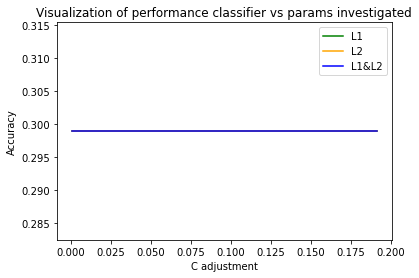

In [0]:
# visualize performance classifier vs params investigated
plt.plot(indexL1, accuracyL1, color='g', label="L1")
plt.plot(indexL2, accuracyL2, color='orange', label="L2")
plt.plot(indexL1L2, accuracyL1L2, color='blue', label="L1&L2")

plt.xlabel('C adjustment')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Visualization of performance classifier vs params investigated')
plt.show()

*Explain answer here*

Our parameter selection does not seem to be justified. For all of our possibilites, we have have the same accuracy of less than 30%. This indicates our prediction task and methods did not work as planned. This could be do to the fact that there are so many different variables that go into whether a genetic variant actually is pathogenic or benign. While I do not believe we have data snooping because there really is not a big reveal or a significant finding, I do believe there is a serious issue with our task as well as with the analysis of the variables we are using.

### ***15 points***
Compare the performance of your "best" logistic regression optimization procedure to the procedure used in scikit-learn. Visualize the performance differences in terms of training time and classification performance. Discuss the results. 

In [0]:
# visualize performance differences training time our best logistic regression optimization procedure
# visualize performance classification our best logistic regression optimization procedure

import time
import sklearn
startL2= time.time()
 
bfgslr2 = BFGSBinaryLogisticRegressionL2(_,2,C=C_step) 
bfgslr2.fit(lr_data_X_train, lr_data_Y_train)
yhat = bfgslr2.predict(lr_data_X_test)

endL2= time.time()
training_time_my_BFGSL2= endL2- startL2
my_bfgslr2_accuracy = accuracy_score(lr_data_Y_test,yhat)
print('My Training Time:', training_timeBFGSL2)
print('My Accuracy:', my_accuracy)


My Training Time: 0.021033763885498047
My Accuracy: 0.29896907216494845


In [0]:
# visualize performance differences training time sci-kit learn
# visualize performance classification sci-kit learn optimization procedure
startL2= time.time()
scikit_bfgslr2 = sklearn.linear_model.LogisticRegression(penalty='l2', dual=False, tol=0.0001, 
                                        C=0.01, fit_intercept=True, 
                                        solver='lbfgs', max_iter=1000).fit(lr_data_X_train, lr_data_Y_train)
yhat = scikit_bfgslr2.predict(lr_data_X_test)
endL2= time.time()
training_time_scikit_BFGSL2= endL2 - startL2
scikit_bfgslr2_accuracy = accuracy_score(lr_data_Y_test,yhat)
print('Scikit-learn training time:', training_time_scikit_BFGSL2)
print('Scikit-learn accuracy:', scikit_bfgslr2_accuracy)


Scikit-learn training time: 5.298713207244873
Scikit-learn accuracy: 0.9925207196280574


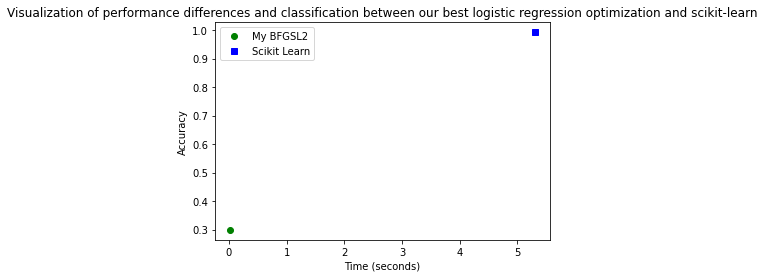

In [0]:
plt.plot(training_time_my_BFGSL2, my_bfgslr2_accuracy, 'go', label="My BFGSL2")
plt.plot(training_time_scikit_BFGSL2, scikit_bfgslr2_accuracy, 'bs', label="Scikit Learn")

plt.xlabel('Time (seconds)')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Visualization of performance differences and classification between our best logistic regression optimization and scikit-learn')
plt.show()

*Explain answer here* <br/>
Since performance doesnt change between values of C and regularization techniques, we choose BFGSBinaryLogisticRegressionL2 to compare with scikit-learn
<br/><br/>
From the visualization of performance and time, it is very obvious that scikit learn is much better than our technique. While our technique takes very little time, it is obvious that it was at the detriment of our performance. While our performance is around 30%, scikit learn's accuracy is close to 90-95%, which is the accuracy we originally wanted for our data. While scikit learn takes more time, this is not a huge issue as this is a system that would run in the background and not at a moment's notice.

## Deployment [***10 points***]
Which implementation of logistic regression would you advise be used in a deployed machine learning model, your implementation or scikit-learn (or other third party)? Why?

*Explain answer here*

Scikit learn is what I would suggest be used for this dataset. Our implementation does not find the best accuracy rates, they are around 30% which is no where near good enough to be used in any deployment for the medical field. Scikit learn is created to run these sort of calculations in a quick and correct manner. It has been created and refined more than our implementation, and thus would have a better accuracy than we will be able to reach in our implementation. Scikit learn was written by those with a deeper knowledge than us as well, and thus performs better. Our implementation does not do well for our classification task. I would not suggest our implementation. Scikit learn had the best accuracy, which is what matters for our dataset since it involves people and their health.

## Exceptional Work [***10 points***]
You have free reign to provide additional analyses. One idea: Update the code to use either "one-versus-all" or "one-versus-one" extensions of binary to multi-class classification. One idea (required for 7000 level students): Implement an optimization technique for logistic regression using mean square error as your objective function (instead of binary entropy). Your solution should be able to solve the binary logistic regression problem in one update step.

In [0]:
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.0001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.classifiers_ = []
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            hblr = BFGSBinaryLogisticRegressionL2(self.eta,self.iters,self.C)
            hblr.fit(X,y_binary)
            #print(accuracy(y_binary,hblr.predict(X)))
            # add the trained classifier to the list
            self.classifiers_.append(hblr)
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row
    
lr = MultiClassLogisticRegression(_,iterations=10,C=0.001)
lr.fit(lr_data_X_train, lr_data_Y_train)
print(lr)

yhat = lr.predict(lr_data_X_test)
print('Accuracy of: ',accuracy_score(lr_data_Y_test,yhat))

C:\Users\Skyler\Anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Skyler\Anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


MultiClass Logistic Regression Object with coefficients:
[[-9.11825125e-01  2.89582045e-03 -2.42438456e-02 -2.58104660e-02
   3.44926242e-01 -6.70948715e-01 -1.74369552e-01 -4.73912680e+00]
 [ 1.90027714e+00  1.66210495e-02  6.74284757e-02  6.78049161e-02
  -2.16573934e-01  1.32948465e+00  1.84421063e-01  8.38275969e-01]
 [-8.01965604e+00  4.55615582e-03 -1.73492122e-01 -1.79333349e-01
   1.16279020e-01 -5.93668553e+00 -1.45443650e+00  3.90610050e+00]
 [-6.77156446e-01 -6.91091717e-01 -1.16439156e-02 -1.18316729e-02
  -8.22662046e-01 -5.17026464e-01 -1.70815981e-01 -1.28876995e+00]]
Accuracy of:  0.02809783707297352


The above code is for MultiClass Logistic Regression. Our version of MultiClass Regression is very bad when it comes to our dataset. As it is less than 3% accurate, this means that it would not be useful in any way, shape, or form. 